In [1]:
import sys

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import torch
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import cebra.datasets
from cebra import CEBRA
import cebra

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(DEVICE)

cuda


In [2]:
cortex = 'VISpm'
seed=333
num_neurons = 800

ca_train = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-train-10-{seed}')
#np_train = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')
#joint_train = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-train-10-{seed}')

ca_test = cebra.datasets.init(f'allen-movie-one-ca-{cortex}-{num_neurons}-test-10-{seed}')
#np_test = cebra.datasets.init(f'allen-movie-one-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')
#joint_test = cebra.datasets.init(f'allen-movie-one-ca-neuropixel-{cortex}-{num_neurons}-test-10-{seed}')


(-47.03983612060547, 43.14802856445313, -52.48082580566406, 44.507330322265624)

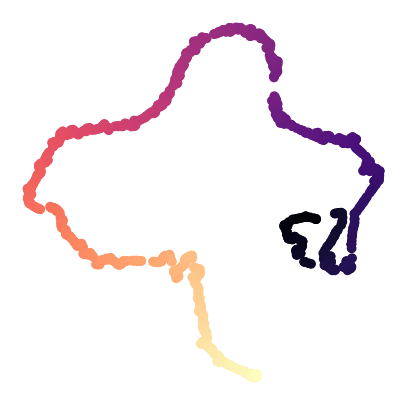

In [4]:
ca_train

dino_tsne = TSNE(n_components = 2)
dino_tsne_viz = dino_tsne.fit_transform(ca_train.index[:900,:])

fig = plt.figure(figsize = (5,5))
plt.scatter(dino_tsne_viz[:,0], dino_tsne_viz[:,1], cmap = 'magma', c = np.arange(900))
plt.axis('off')

In [7]:
print(ca_train.index.shape)
print(ca_test.index.shape)

torch.Size([8100, 768])
torch.Size([900, 768])


In [ ]:
train_steps = 10000
ca_loader = cebra.data.ContinuousDataLoader(ca_train, num_steps = train_steps, batch_size = 512, conditional = 'time_delta', time_offset =1)